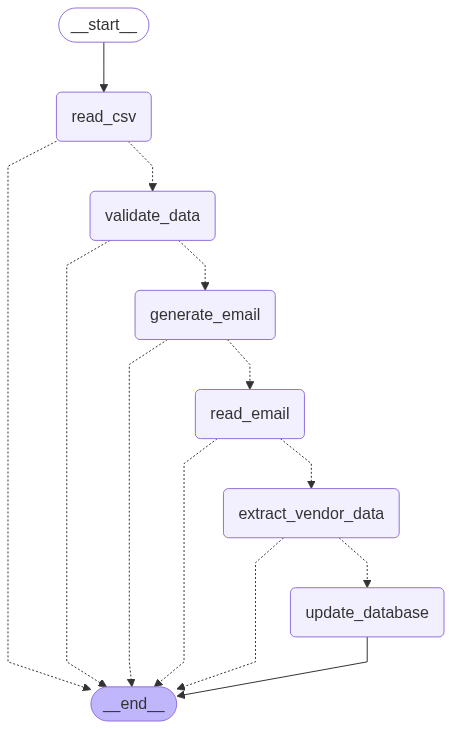

CSV read successfully
Generated email for vendor ID V00001
Generated email for vendor ID V00018
Generated email for vendor ID V00020
[{'vendor_id': 'V00001', 'email_address': 'wstout@hanson.com', 'email_content': "[Subject: Request for Missing/Invalid Vendor Information]\n\nDear [Vendor],\n\nWe are reviewing your vendor information for Vendor ID V00001 and noticed the following issues:\n- Phone number '160' is invalid (must be exactly 10 digits)\n\nPlease provide the correct information at your earliest convenience to ensure your vendor profile is complete.\n\nThank you,"}, {'vendor_id': 'V00018', 'email_address': 'arichards@hotmail.com', 'email_content': '[Vendor Management Team]'}, {'vendor_id': 'V00020', 'email_address': 'kolson@moon-strickland.net', 'email_content': "[Vendor's Name],\n\nWe are reviewing your vendor information for Vendor ID V00020 and noticed the following issues:\n- Phone number '76' is invalid (must be exactly 10 digits)\n\nPlease provide the correct information 

In [5]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START  
from langgraph.prebuilt import ToolNode
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from dotenv import load_dotenv
from pydantic import Field,BaseModel
from langchain_core.tools import tool
from typing import Dict, Optional, TypedDict,List
import json
import re
import ast
import pandas as pd
from IPython.display import Image, display
import json
import requests
from typing import Dict, Optional, TypedDict, Annotated
from langgraph.graph import StateGraph, END
import os
import warnings
warnings.filterwarnings('ignore')
load_dotenv()
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
embed = OpenAIEmbeddings(
    model="text-embedding-3-small"
)
model=ChatOpenAI()




import pandas as pd
import json
from typing import Dict, Optional, TypedDict
from langgraph.graph import StateGraph, END, START
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableSequence
# Assuming 'model' is a LangChain-compatible LLM (e.g., Grok 3)
from langchain_core.language_models import BaseLanguageModel
import warnings
warnings.filterwarnings('ignore')
load_dotenv()
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
embed = OpenAIEmbeddings(
    model="text-embedding-3-small"
)
model=ChatOpenAI()

CSV_FILE = "/Users/sachinbeast/Desktop/Desktop - Sachin’s MacBook Air/system/hackathin/database/vendors_dataset.csv"
EMAIL_FILE = "/Users/sachinbeast/Desktop/Desktop - Sachin’s MacBook Air/system/hackathin/data/email.txt"

class VendorState(TypedDict):
    csv_data: pd.DataFrame
    validation_results:List[Dict]
    generated_emails: List[Dict]
    email_content: str
    extracted_data: Optional[Dict]
    update_status: str

def read_csv(state: VendorState) -> VendorState:
    """Read vendor data from CSV file."""
    try:
        df = pd.read_csv(CSV_FILE)
        expected_columns = ['Vendor_ID','Vendor_Name','Bank_Account','Address','Name','Email','Phone_Number']
        if not all(col in df.columns for col in expected_columns):
            raise ValueError("CSV missing required columns")
        state["csv_data"] = df
        state["update_status"] = "CSV read successfully"
        print("CSV read successfully")
        return state
    except Exception as e:
        state["update_status"] = f"Error reading CSV: {str(e)}"
        print(f"Error reading CSV: {str(e)}")
        return state
    
def validate_data(state: VendorState) -> VendorState:

    if state["update_status"].startswith("Error"):

        state["update_status"] = "Error No CSV data to validate"
        print("No CSV data to validate")
        return state
    try: 
        df = state["csv_data"]
        validation_results = []
        
        email_regex = r"^[\w\.-]+@[\w\.-]+\.\w+$"
        for _, row in df.iterrows():
            vendor_id = row["Vendor_ID"]
            issues = []
            
            # Validate phone number (10 digits)
            phone = str(row["Phone_Number"]) if pd.notnull(row["Phone_Number"]) else ""
            if not re.match(r"^\d{10}$", phone):
                issues.append(f"Phone number '{phone}' is invalid (must be exactly 10 digits)")
            
            # Validate bank account (not empty)
            bank_account = str(row["Bank_Account"]) if pd.notnull(row["Bank_Account"]) else ""
            if not bank_account or bank_account.lower() in ["not provided", ""]:
                issues.append("Bank account is missing")
            
            # Validate email address (present and valid format)
            email = str(row["Email"]) if pd.notnull(row["Email"]) else ""
            if not email or not re.match(email_regex, email):
                issues.append(f"Email address '{email}' is invalid or missing")
            
            validation_results.append({
                "vendor_id": vendor_id,
                "issues": issues,
                "email_address": email
            })
        
        state["validation_results"] = validation_results
        state["update_status"] = "Data validation completed"
        return state

    except Exception as e:
            state["update_status"] = f"Error validating data"
            print(f"Error in validation")
            return state


def generate_email(state: VendorState) -> VendorState:
        if state["update_status"].startswith("Error"):

            state["update_status"] = "No validation results to compile"
            print("No validation result")
            return state

        try:

            prompt = PromptTemplate(
            template='''You are an AI assistant tasked with generating an email to request missing or invalid vendor information. 
    The vendor details and issues are provided below. Create a professional email addressed to the vendor's 
    email address, requesting the missing or invalid data. Include the vendor ID in the email for reference. 
    Return the email content as plain text.

    Vendor Details:
    - Vendor ID: {vendor_id}
    - Email Address: {email_address}
    - Issues: {issues}

    Output:
    [Subject: Request for Missing/Invalid Vendor Information]

    Dear [Vendor],

    We are reviewing your vendor information for Vendor ID {vendor_id} and noticed the following issues:
    {issues}

    Please provide the correct information at your earliest convenience to ensure your vendor profile is complete.

    Thank you,
        ''',
            input_variables=['vendor_id','email_address','issues']
        )
            
            

            generated_emails = []
            for result in state["validation_results"]:
                if result["issues"] and result["email_address"]:
                    chain = prompt | model 
                    email_content = chain.invoke({'vendor_id':result["vendor_id"],'email_address':result["email_address"]
                                                            ,'issues':"\n".join([f"- {issue}" for issue in result["issues"]])})
                    if email_content:
                        generated_emails.append({
                            "vendor_id": result["vendor_id"],
                            "email_address": result["email_address"],
                            "email_content": email_content.content
                        })
                    print(f"Generated email for vendor ID {result['vendor_id']}")
        
            state["generated_emails"] = generated_emails
            print(generated_emails)
            state["update_status"] = "Emails generated"
            print("Emails generated")
            print(state["generated_emails"])
            
            return state
        
        except Exception as e:
            state["update_status"] = f"Error generating email"
            print(f"Error in generating email")
            return state

def read_email(state: VendorState) -> VendorState:
    """Read email content from file."""

    try:
        if not os.path.exists(EMAIL_FILE):
            state["update_status"] = "Email file not found"
            print("Email file not found")
            return state
        
        with open(EMAIL_FILE, "r", encoding="utf-8") as f:
            content = f.read().strip()
            if not content:
                state["update_status"] = "Email file is empty"
                print("Email file is empty")
                return state
            state["email_content"] = content
            state["update_status"] = "Email read successfully"
            print("Email read successfully")
        return state
    except Exception as e:
        state["update_status"] = f"Error reading email: {str(e)}"
        print(f"Error reading email: {str(e)}")
        return state

def extract_vendor_data(state: VendorState) -> VendorState:
    """Extract vendor ID and data from email using LLM."""
    if not state.get("email_content"):
        state["update_status"] = "No email content to process"
        print("No email content to process")
        return state
    
    prompt = PromptTemplate(
        template='''You are an AI assistant tasked with determining which database column(s) 
        to update based on an email and a task. The database columns are:

        Columns:
        Vendor_Name
        Bank_Account
        Address
        Name
        Email
        Phone_Number
        Vendor_ID

        Identify the column to update and the corresponding value from the email.
        Return the result in DICT format, listing the column, vendor ID, and content.
        If no update is needed or the task is unclear, return a dict with null values.

        {{
          "column": null,
          "Vendor_ID": null,
          "content": null
        }}

        Email Content:
        {email}
        ''',
        input_variables=['email']
    )

    class Update(BaseModel):
        column: str = Field(description='name of the column in database')
        Vendor_ID: str = Field(description='ID of the vendor')
        content: str = Field(description='content to be updated')
    
    parser = JsonOutputParser(pydantic_object=Update)
    
    chain = prompt | model | parser

    try:
        extracted_data = chain.invoke({'email': state["email_content"]})
        state["extracted_data"] = extracted_data
        state["update_status"] = "Vendor data extracted"
        print("Vendor data extracted:", state["extracted_data"])
    except Exception as e:
        state["update_status"] = f"Error extracting vendor data: {str(e)}"
        print(f"Error extracting vendor data: {str(e)}")
        state["extracted_data"] = {"column": None, "Vendor_ID": None, "content": None}
    
    return state

def update_database(state: VendorState) -> VendorState:
    """Update the specified column in the CSV for the matched vendor ID."""
    # if not state.get("csv_data") or not state.get("extracted_data") or not state["extracted_data"].get("Vendor_ID"):
    #     state["update_status"] = "No valid data to update database"
    #     print("No valid data to update database")
    #     return state

    vendor_id = state["extracted_data"]["Vendor_ID"]
    content = state["extracted_data"]["content"]
    column = state["extracted_data"]["column"]
    df = state["csv_data"]
    
    try:
        if vendor_id and content and column in df.columns:
            df.loc[df["Vendor_ID"].astype(str) == str(vendor_id), column] = content
            df.to_csv(CSV_FILE, index=False)  # Save the updated CSV
            state["csv_data"] = df
            state["update_status"] = f"Updated {column} for vendor ID {vendor_id} to {content}"
            print(f"Updated {column} for vendor ID {vendor_id} to {content}")
        else:
            state["update_status"] = "Invalid vendor ID, content, or column"
            print("Invalid vendor ID, content, or column")
    except Exception as e:
        state["update_status"] = f"Error updating database: {str(e)}"
        print(f"Error updating database: {str(e)}")
    return state

def check_status(state: VendorState) -> str:
    """Determine the next step based on the state."""
    status = state.get("update_status", "")
    
    # Check for errors or critical failures
    if status.startswith("Error") or status in [
        "No CSV data to validate",
        "No validation results to process"
    ]:
        return END
    
    # Route to the next node based on state
    if state.get("csv_data") is None:
        return "read_csv"
    if state.get("validation_results") is None:
        return "validate_data"
    if state.get("generated_emails") is None:
        return "generate_email"
    if not state.get("email_content"):
        return "read_email"
    if not state.get("extracted_data"):
        return "extract_vendor_data"
    return "update_database"



workflow = StateGraph(VendorState)

# Add nodes

workflow.add_node("read_csv", read_csv)
workflow.add_node("validate_data", validate_data)
workflow.add_node("generate_email", generate_email)
workflow.add_node("read_email", read_email)
workflow.add_node("extract_vendor_data", extract_vendor_data)
workflow.add_node("update_database", update_database)

workflow.add_conditional_edges(
    "read_csv",
    check_status,
    {
        "validate_data": "validate_data",
        END: END
    }
)
workflow.add_conditional_edges(
    "validate_data",
    check_status,
    {
        "generate_email": "generate_email",
        END: END
    }
)
workflow.add_conditional_edges(
    "generate_email",
    check_status,
    {
        "read_email": "read_email",
        END: END
    }
)
workflow.add_conditional_edges(
    "read_email",
    check_status,
    {
        "extract_vendor_data": "extract_vendor_data",
        END: END
    }
)

workflow.add_conditional_edges(
    "extract_vendor_data",
    check_status,
    {"update_database": "update_database", END: END}
)
workflow.add_edge("update_database", END)


workflow.set_entry_point("read_csv")

# Compile and run the graph
def main():
    app = workflow.compile()
    
# View
    display(Image(app.get_graph().draw_mermaid_png()))
    initial_state = VendorState(
        csv_data=None,
        validation_results=None,
        generated_emails= None,
        email_content="",
        extracted_data=None,
        update_status=str
    )
    result = app.invoke(initial_state)
    # print("\nFinal State:")
    # print(json.dumps(result, indent=2, default=str))

if __name__ == "__main__":
    main()